In this kernel we will generate artificial microscope cell images that can be used to balance our dataset.

These are the basic steps:

1. Choose a real image
2. Crop out a section of the background.
3. Crop out three different cells.
4. Crop out three examples of noise or artifacts.
5. Resize the background crop to 1200 x 1600
6. Randomly add a random number of cells and noise to this background, at random locations. The cells and noise will be augmented by adding a random amount of 90 degree counterclockwise rotation. The background will also be randomly rotated.
7. Save the newly created artificial image as a png file.

# Import packages

In [14]:
import pandas as pd
import numpy as np
import os

import cv2

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Helper functions

In [16]:
# Global variable

root_dir = '../data/malaria_bbbc_80k/malaria/'

In [6]:
# extract bounding box information into separate col

def extract_nested_list(it):
    if isinstance(it, list):
        for sub_it in it:
            yield from extract_nested_list(sub_it)
    elif isinstance(it, dict):
        for value in it.values():
            yield from extract_nested_list(value)
    else:
        yield it

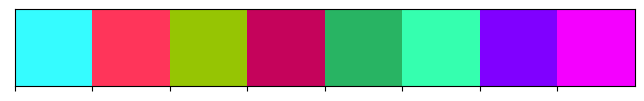

In [9]:
# Custom colors for plots

custom_colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF', '#8000FF', '#F400FF']
hex2rgb = lambda hx: (int(hx[1:3],16),int(hx[3:5],16),int(hx[5:7],16))
rgbcolors = list(map(hex2rgb, custom_colors))[1:]
sns.palplot(sns.color_palette(custom_colors))

In [10]:
# Plot original image and image with bounding boxes

def plot_data_example(df: pd.DataFrame,
                      root_dir: str,
                      img_path: str, 
                      colors: dict):

    image = cv2.imread(os.path.join(root_dir, img_path)).astype("uint8")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = np.zeros(image.shape, dtype="uint8")

    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(25, 8))
    ax[1].imshow(image, aspect="auto")
    ax[1].set_title("Original Image", fontsize=22, fontweight='bold', y=1.07)
    ax[0].set_title("Image with Bounding Boxes", fontsize=22, fontweight='bold', y=1.07)


    bb_info = df.loc[df["pathname"] == img_path, ["x_min", "x_max", "y_min", "y_max", "category"]].values
    for i_bb in bb_info:

        cmin, cmax, rmin, rmax = i_bb[:-1].astype('int')
        label = i_bb[-1]
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1, 
                                 edgecolor=label2hex[label], facecolor='none')
        boxes[rmin:rmax, cmin:cmax] = label2rgb[label]

        ax[0].add_patch(bbox)
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))
        ax[0].imshow(image, aspect="auto")
        ax[0].imshow(boxes,  alpha=0.3, aspect="auto")
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))

    plt.tight_layout()
    plt.show()

# Data preparation

In [2]:
# Load json files

train_df = pd.read_json("../data/malaria_bbbc_80k/malaria/training.json")
test_df = pd.read_json("../data/malaria_bbbc_80k/malaria/test.json")
print(train_df.shape, test_df.shape)

(1208, 2) (120, 2)


In [3]:
train_df["checksum"] = train_df['image'].apply(lambda x: x["checksum"])
train_df["pathname"] = train_df['image'].apply(lambda x: x["pathname"][1:])
train_df["shape"] = train_df['image'].apply(lambda x: x["shape"])
train_df.head()

image  \
0  {'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...   
1  {'checksum': '1225a18efce159eddf7b0e80e0ea642c...   
2  {'checksum': '3eaf840523c30fdf38897ffa01e194eb...   
3  {'checksum': '8a111dffacfa433029492780b9535091...   
4  {'checksum': 'ccef403e971460b86444cca669e68ca1...   

                                             objects  \
0  [{'bounding_box': {'minimum': {'r': 1057, 'c':...   
1  [{'bounding_box': {'minimum': {'r': 734, 'c': ...   
2  [{'bounding_box': {'minimum': {'r': 724, 'c': ...   
3  [{'bounding_box': {'minimum': {'r': 563, 'c': ...   
4  [{'bounding_box': {'minimum': {'r': 618, 'c': ...   

                           checksum  \
0  676bb8e86fc2dbf05dd97d51a64ac0af   
1  1225a18efce159eddf7b0e80e0ea642c   
2  3eaf840523c30fdf38897ffa01e194eb   
3  8a111dffacfa433029492780b9535091   
4  ccef403e971460b86444cca669e68ca1   

                                          pathname  \
0  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1  images/10be6380-cbbb-4886-8b9e-ff56b1710576.png   
2  images/6b14c855-8561-417c-97a4-63fa552842fd.png   
3  images/13099edb-35d9-438f-b093-2cf2ebf9d255.png   
4  images/2559636b-f01a-4414-93da-210c3b12d153.png   

                                   shape  
0  {'r': 1200, 'c': 1600, 'channels': 3}  
1  {'r': 1200, 'c': 1600, 'channels': 3}  
2  {'r': 1200, 'c': 1600, 'channels': 3}  
3  {'r': 1200, 'c': 1600, 'channels': 3}  
4  {'r': 1200, 'c': 1600, 'channels': 3}

In [4]:
df = pd.DataFrame(
    [
     dict(pathname=row['pathname'], 
          shape=row['shape'],
          checksum=row['checksum'],
          **bb_info) 
     for _, row in train_df.iterrows() 
     for bb_info in row['objects']
     ]
     )

df.head()

pathname  \
0  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
2  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
3  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
4  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   

                                   shape                          checksum  \
0  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
1  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
2  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
3  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
4  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   

                                        bounding_box        category  
0  {'minimum': {'r': 1057, 'c': 1440}, 'maximum':...  red blood cell  
1  {'minimum': {'r': 868, 'c': 1303}, 'maximum': ...  red blood cell  
2  {'minimum': {'r': 578, 'c': 900}, 'maximum': {...  red blood cell  
3  {'minimum': {'r': 304, 'c': 611}, 'maximum': {...  red blood cell  
4  {'minimum': {'r': 198, 'c': 881}, 'maximum': {...  red blood cell

In [11]:
# Extract bounding box info to separate cols

df['x_min'] = -1
df['y_min'] = -1
df['x_max'] = -1
df['y_max'] = -1

df[['y_min', 'x_min', 'y_max', 'x_max']] = np.stack(df['bounding_box'].apply(lambda x: np.array(list(extract_nested_list(x)))))

df['x_min'] = df['x_min'].astype(float)
df['y_min'] = df['y_min'].astype(float)
df['x_max'] = df['x_max'].astype(float)
df['y_max'] = df['y_max'].astype(float)

df['w'] = df['x_max'] - df['x_min']
df['h'] = df['y_max'] - df['y_min']

df['x_center'] = df['x_min'] + df['w'] / 2
df['y_center'] = df['y_min'] + df['h'] / 2

df.drop(columns=['bounding_box'], inplace=True)

df.head()

pathname  \
0  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
2  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
3  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
4  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   

                                   shape                          checksum  \
0  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
1  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
2  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
3  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   
4  {'r': 1200, 'c': 1600, 'channels': 3}  676bb8e86fc2dbf05dd97d51a64ac0af   

         category   x_min   y_min   x_max   y_max      w      h  x_center  \
0  red blood cell  1440.0  1057.0  1540.0  1158.0  100.0  101.0    1490.0   
1  red blood cell  1303.0   868.0  1403.0   971.0  100.0  103.0    1353.0   
2  red blood cell   900.0   578.0  1008.0   689.0  108.0  111.0     954.0   
3  red blood cell   611.0   304.0   713.0   408.0  102.0  104.0     662.0   
4  red blood cell   881.0   198.0  1003.0   312.0  122.0  114.0     942.0   

   y_center  
0    1107.5  
1     919.5  
2     633.5  
3     356.0  
4     255.0

In [12]:
# Extract image shape info to separate cols

df['img_width'] = -1
df['img_height'] = -1
df['channels'] = -1
df['pixels'] = -1

df[['img_height','img_width', 'channels']] = np.stack(df['shape'].apply(lambda x: np.array(list(extract_nested_list(x)))))
df['pixels'] = df['img_width'] * df['img_height'] * df['channels']

df.drop(columns=['shape'], inplace=True)

df.head()

pathname  \
0  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
2  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
3  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
4  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   

                           checksum        category   x_min   y_min   x_max  \
0  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell  1440.0  1057.0  1540.0   
1  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell  1303.0   868.0  1403.0   
2  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   900.0   578.0  1008.0   
3  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   611.0   304.0   713.0   
4  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   881.0   198.0  1003.0   

    y_max      w      h  x_center  y_center  img_width  img_height  channels  \
0  1158.0  100.0  101.0    1490.0    1107.5       1600        1200         3   
1   971.0  100.0  103.0    1353.0     919.5       1600        1200         3   
2   689.0  108.0  111.0     954.0     633.5       1600        1200         3   
3   408.0  102.0  104.0     662.0     356.0       1600        1200         3   
4   312.0  122.0  114.0     942.0     255.0       1600        1200         3   

    pixels  
0  5760000  
1  5760000  
2  5760000  
3  5760000  
4  5760000

In [15]:
# Encoding label

lb = LabelEncoder()
lb.fit(df["category"])
df["label"] = lb.transform(df["category"])

df.head()

pathname  \
0  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
1  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
2  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
3  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   
4  images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png   

                           checksum        category   x_min   y_min   x_max  \
0  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell  1440.0  1057.0  1540.0   
1  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell  1303.0   868.0  1403.0   
2  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   900.0   578.0  1008.0   
3  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   611.0   304.0   713.0   
4  676bb8e86fc2dbf05dd97d51a64ac0af  red blood cell   881.0   198.0  1003.0   

    y_max      w      h  x_center  y_center  img_width  img_height  channels  \
0  1158.0  100.0  101.0    1490.0    1107.5       1600        1200         3   
1   971.0  100.0  103.0    1353.0     919.5       1600        1200         3   
2   689.0  108.0  111.0     954.0     633.5       1600        1200         3   
3   408.0  102.0  104.0     662.0     356.0       1600        1200         3   
4   312.0  122.0  114.0     942.0     255.0       1600        1200         3   

    pixels  label  
0  5760000      3  
1  5760000      3  
2  5760000      3  
3  5760000      3  
4  5760000      3

# Some basic technique

## Cropping
    
    Imagine that we have a matrix.

    x and y are the coordinates of a point in the matrix.
    h and w are the height and width.
    Take note that in images the origin (0,0) is located in the top left corner.

In [35]:
image_path = root_dir + df["pathname"][0]

image = cv2.imread(image_path).astype("uint8")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
ax[0].imshow(image)

y=500
x=850
h=110
w=130

# use numpy slicing to execute the crop
cell_crop = image[y:y+h, x:x+w]

ax[1].imshow(cell_crop)

plt.show()

## Combining 2 images

In [44]:
# image_1

pathname_1 = root_dir + df["pathname"][0]

# read the image
image_1 = cv2.imread(pathname_1)

# image_2

pathname_2 = root_dir + df["pathname"][250]
# read the image
image_2 = cv2.imread(pathname_2)


# Combine the images
new_image = np.minimum(image_1, image_2)

image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 8))

ax[0].imshow(image_1)
ax[1].imshow(image_2)
ax[2].imshow(new_image)

plt.show()

Take note that we used np.minimum() above. Sometimes depending on the background/foreground pixel values you may need to use np.maximum().

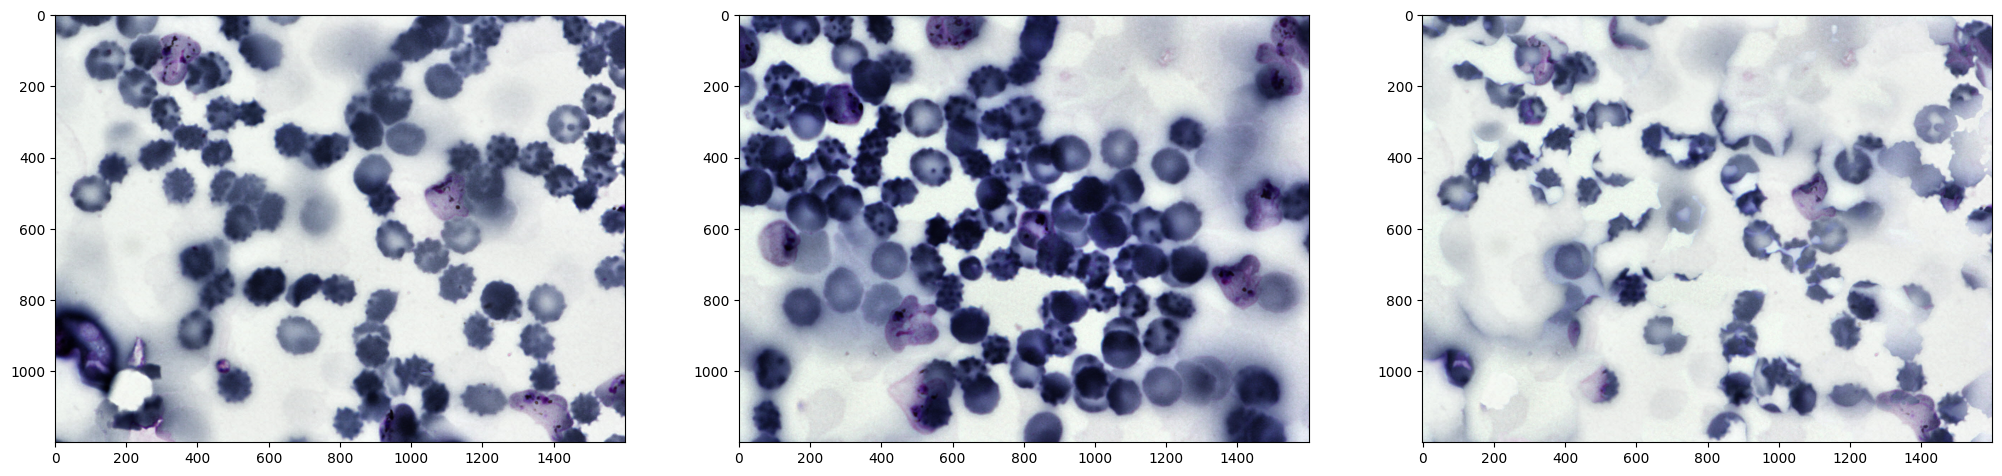

In [45]:
# image_1

pathname_1 = root_dir + df["pathname"][0]

# read the image
image_1 = cv2.imread(pathname_1)

# image_2

pathname_2 = root_dir + df["pathname"][250]
# read the image
image_2 = cv2.imread(pathname_2)


# Combine the images
new_image = np.maximum(image_1, image_2)

image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 8))

ax[0].imshow(image_1)
ax[1].imshow(image_2)
ax[2].imshow(new_image)

plt.show()

## Numpy transformations

In [46]:
# Transformations

# rotate 90 degrees, counterclockwise
# k specfies how many times to rotate
img_rotate = np.rot90(image_1, k=1)

# flip horizontally
img_horiz = np.fliplr(image_1)

# flip vertically
img_vert = np.flipud(image_1)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(25, 8))

ax[0].imshow(image_1)
ax[1].imshow(img_rotate)
ax[2].imshow(img_horiz)
ax[3].imshow(img_vert)

plt.show()

# Data synthesizing

In [ ]:
# Create folder
